In [1]:
%load_ext autoreload
%autoreload 2

import os
import gc
import time
import numpy as np; np.random.seed(42)
import pandas as pd
import lightgbm as lgb
import category_encoders as ce
import matplotlib.pyplot as plt

from tsforest.trend import compute_trend_models
from tsforest.forecaster import LightGBMForecaster
from tsforest.utils import make_time_range
from tsforest.metrics import compute_rmse

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, compute_weights, reduce_mem_usage
from evaluation import _WRMSSEEvaluator, WRMSSEEvaluator, Evaluator, WRMSSEEvaluatorL12
from encoding import HierarchicalEncoder

def trimean(array, axis=0):
    quantiles = np.percentile(array, [25, 50, 75], axis=axis)
    return (quantiles[0,:] + 2*quantiles[1,:] + quantiles[2,:])/4

SEEDS = [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71]

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# validation period to be used for test in all this notebook
valid_period = (pd.to_datetime("2016-03-28"), pd.to_datetime("2016-04-24"))

***
# Level 12

In [3]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .reset_index(drop=True)
        .rename({"q":"y"}, axis=1)
       )
data["sales"] = data.eval("y * sell_price")

scaling_input = pd.read_parquet("../input/scaling_input.parquet")
weighting_input = pd.read_parquet("../input/weighting_input.parquet")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46796220 entries, 0 to 46796219
Data columns (total 44 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ts_id              int16         
 1   item_id            int16         
 2   dept_id            int8          
 3   cat_id             int8          
 4   store_id           int8          
 5   state_id           int8          
 6   y                  int16         
 7   ds                 datetime64[ns]
 8   snap_CA            int8          
 9   snap_TX            int8          
 10  snap_WI            int8          
 11  snap_CA_cum        int8          
 12  snap_TX_cum        int8          
 13  snap_WI_cum        int8          
 14  event_name_1       int8          
 15  event_type_1       int8          
 16  event_name_2       int8          
 17  event_type_2       int8          
 18  sell_price         float32       
 19  n_prices           float32       
 20  regular_price      flo

In [4]:
scales_level12 = compute_scaling(scaling_input, 
                                 cut_date=valid_period[0],
                                 agg_columns=["item_id","store_id"]).rename({"q":"s"}, axis=1)

weights_level12 = compute_weights(weighting_input, 
                                  start_date=valid_period[0], level=12)

In [6]:
hierarchy = data.loc[:, ["item_id","dept_id","cat_id"]].drop_duplicates().reset_index(drop=True)

In [7]:
model_params = {
    'objective':'tweedie',
    'tweedie_variance_power': 1.1,
    'metric':'None',
    'num_iterations':100000,
    'early_stopping_rounds':300,
    'max_bin': 127,
    'bin_construct_sample_cnt':6000000,
    'num_leaves': 2**9-1,
    'min_data_in_leaf': 2**9-1,
    'learning_rate': 0.03, 
    #'min_sum_hessian_in_leaf':1e-4,
    'feature_fraction': 0.7,
    #'feature_fraction_bynode':0.9,
    'bagging_fraction':0.66,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'seed':7,
    'boost_from_average': False,
    'first_metric_only': True,
}

time_features = [
    "year",
    "month",
    #"year_week",
    #"year_day",
    "week_day",
    "month_progress", 
    #"week_day_cos",
    #"week_day_sin",
    #"year_day_cos",
    #"year_day_sin",
    "year_week_cos",
    "year_week_sin",
    #"month_cos",
    #"month_sin"
]

exclude_features = [
    "ts_id",
    "store_id",
    "state_id",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "prev_newyear",
    "post_newyear",
    "no_stock_days",
    "sales",
]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "window_shifts":[1,7,28,56],
    "window_functions":["mean","median","std","kurt",],
    "window_sizes":[7,28],
    "exclude_features":exclude_features,
    "categorical_features":{
        "item_id": ("y", ce.GLMMEncoder, None),
        #"item_id": ("sales", HierarchicalEncoder, {"hierarchy":hierarchy, "prior_level":["dept_id",]}),
        "dept_id": "default",
        "cat_id": "default",
        "event_name_1": "default",
    },
    "ts_uid_columns":["item_id",],
}

lagged_features = list()
if "lags" in model_kwargs.keys():
    lag_features = [f"lag{lag}" for lag in model_kwargs["lags"]]
    lagged_features.extend(lag_features)
if "window_functions" in model_kwargs.keys():
    rw_features = [f"{window_func}{window_size}_shift{window_shift}" 
                   for window_func in model_kwargs["window_functions"]
                   for window_size in model_kwargs["window_sizes"]
                   for window_shift in model_kwargs["window_shifts"]]
    lagged_features.extend(rw_features)
    
lagged_features_to_dropna = [feat for feat in lagged_features if feat not in ["skew", "kurt"]]

***

####################################################################################################
##### Validation period: (Timestamp('2016-03-28 00:00:00'), Timestamp('2016-04-24 00:00:00')) ######
####################################################################################################
----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 1 --------------------------------------------
----------------------------------------------------------------------------------------------------
Building the features
Elapsed time building the features: 5.12219469944636 [min]

Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.198894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6121
[LightGBM] [Info] Number of dat

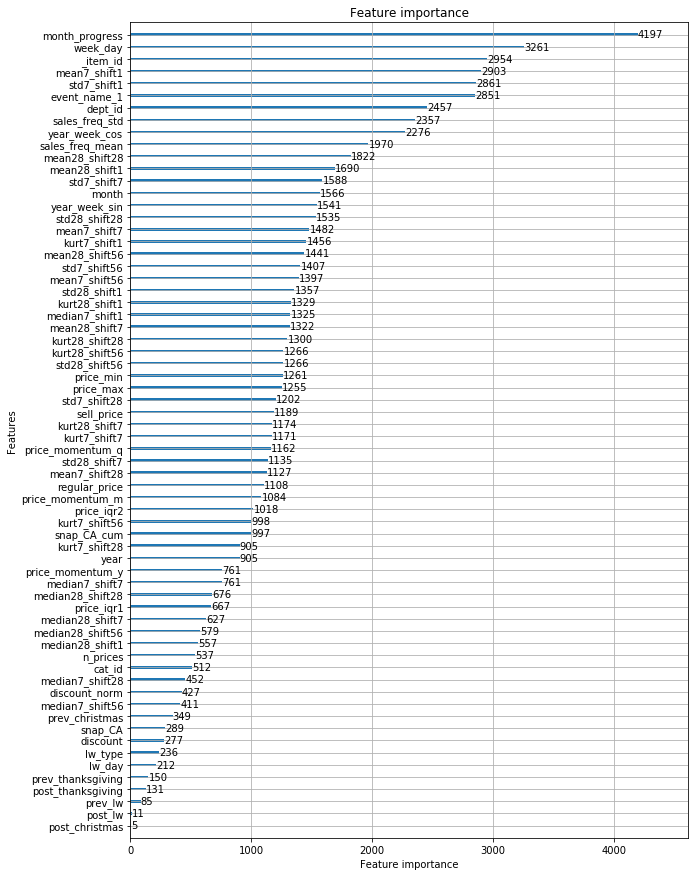

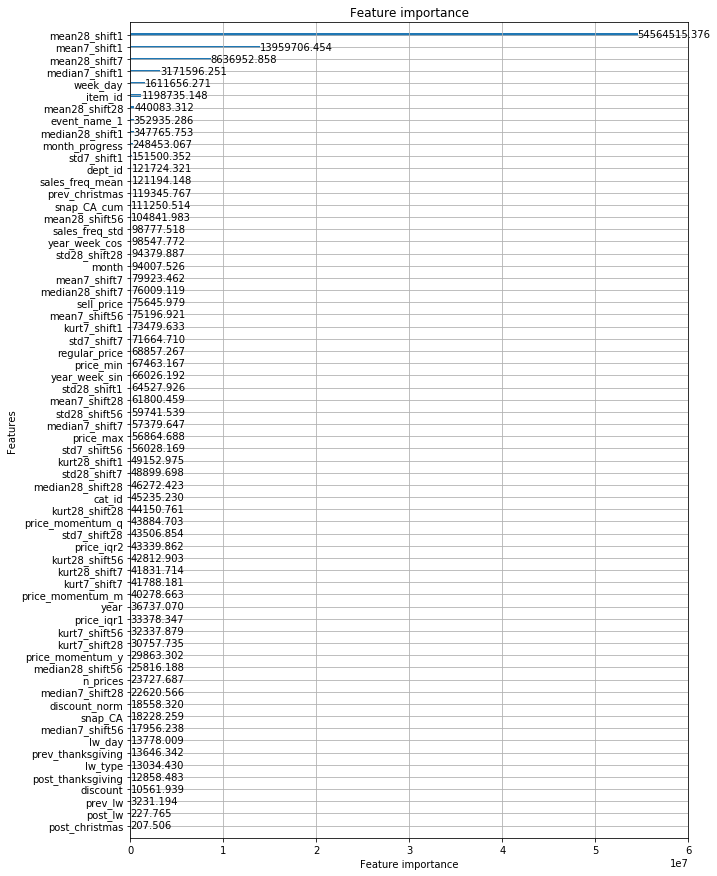

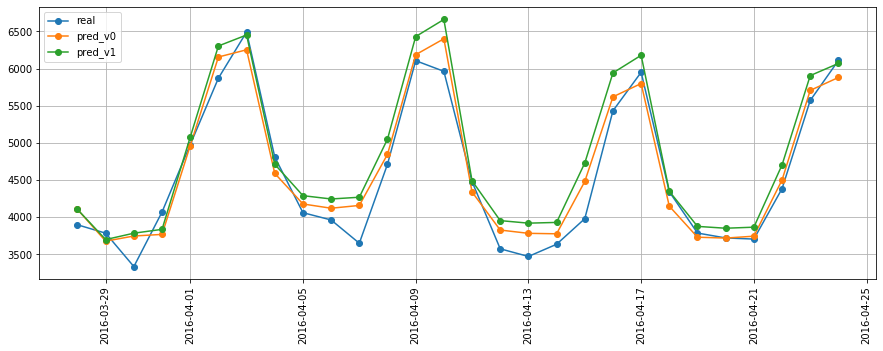

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 2 --------------------------------------------
----------------------------------------------------------------------------------------------------
Building the features
Elapsed time building the features: 4.427905186017354 [min]

Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5852
[LightGBM] [Info] Number of data points in the train set: 2321765, number of used features: 66
Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsseL12: 0.968601
[50]	valid_0's wrmsseL12: 0.873402
[75]	valid_0's wrmsseL12: 0.841673
[100]	valid_0's wrmsseL12: 0.831133
[125]	valid_0's wrmsseL12: 0.827139

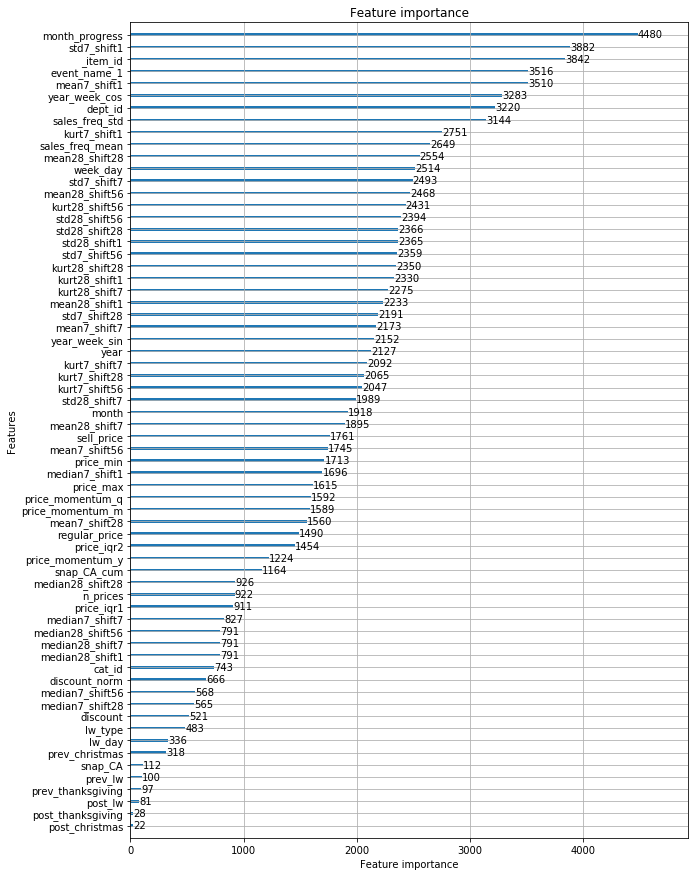

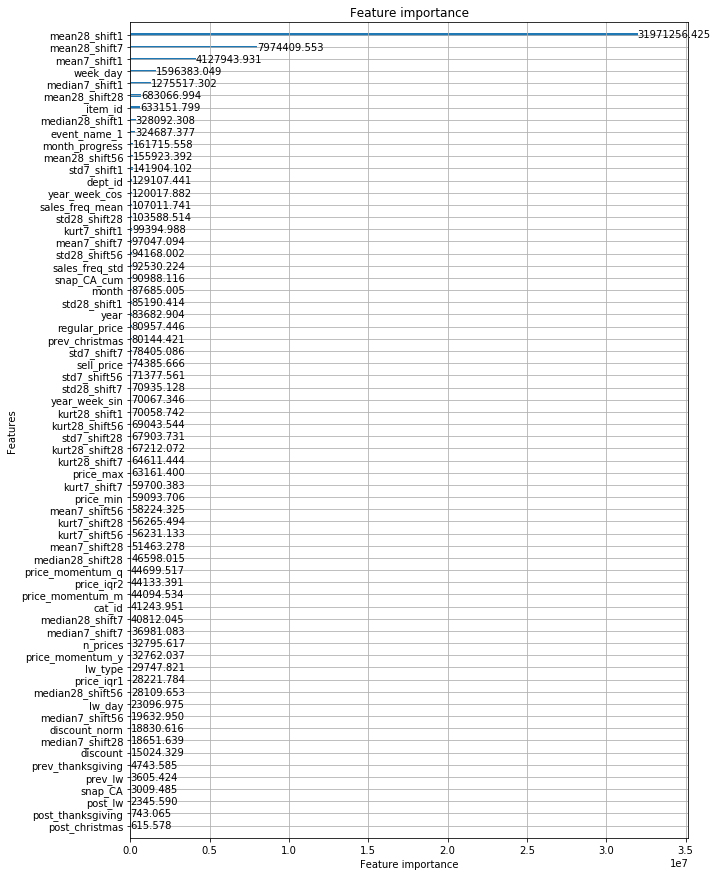

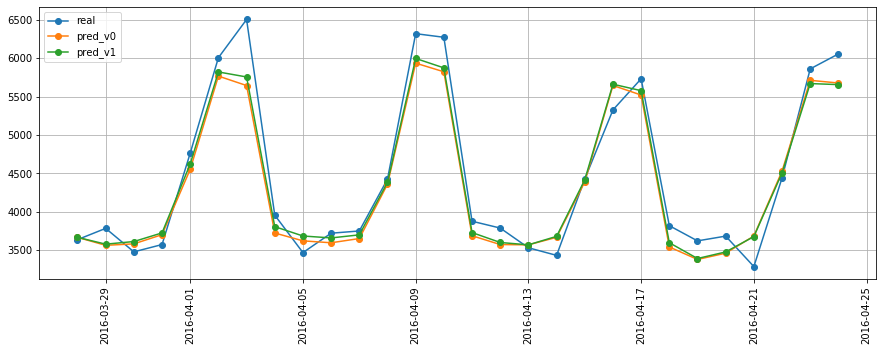

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 3 --------------------------------------------
----------------------------------------------------------------------------------------------------
Building the features
Elapsed time building the features: 4.980833653608958 [min]

Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.134150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6110
[LightGBM] [Info] Number of data points in the train set: 2856354, number of used features: 66
Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsseL12: 0.968782
[50]	valid_0's wrmsseL12: 0.82727
[75]	valid_0's wrmsseL12: 0.783541
[100]	valid_0's wrmsseL12: 0.77232
[125]	valid_0's wrmsseL12: 0.769227
[

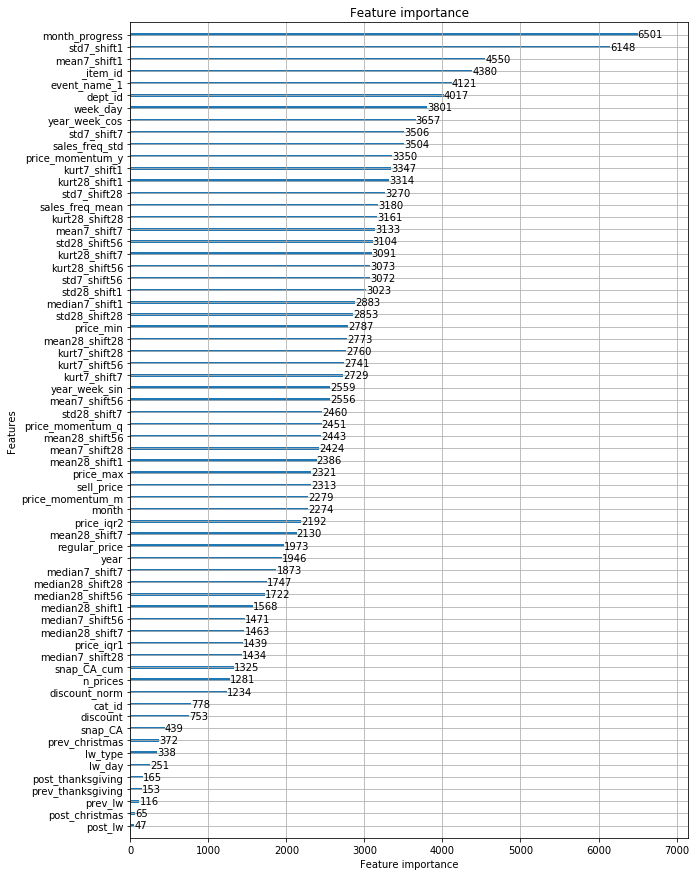

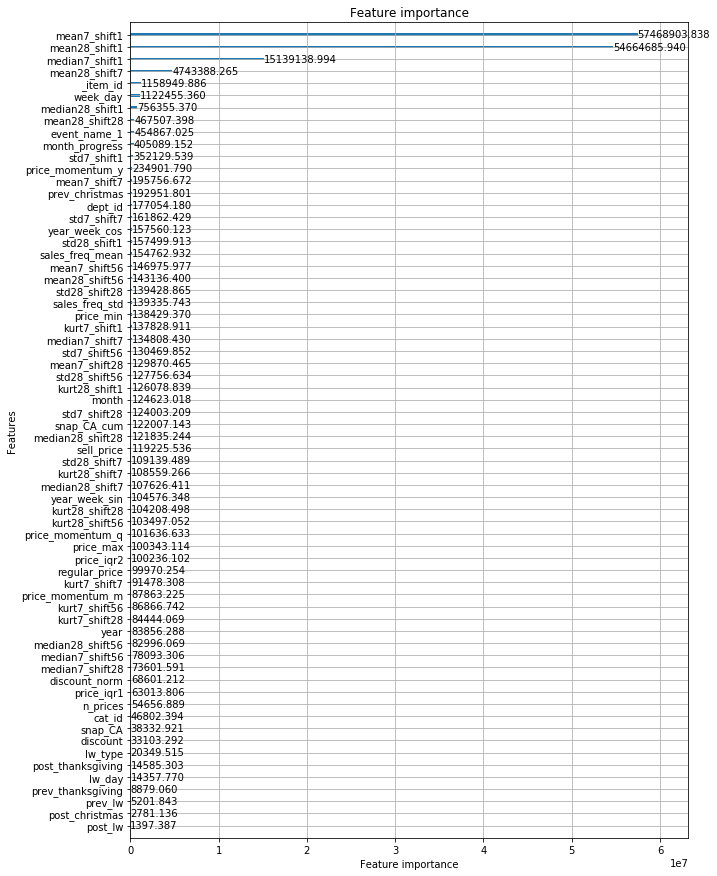

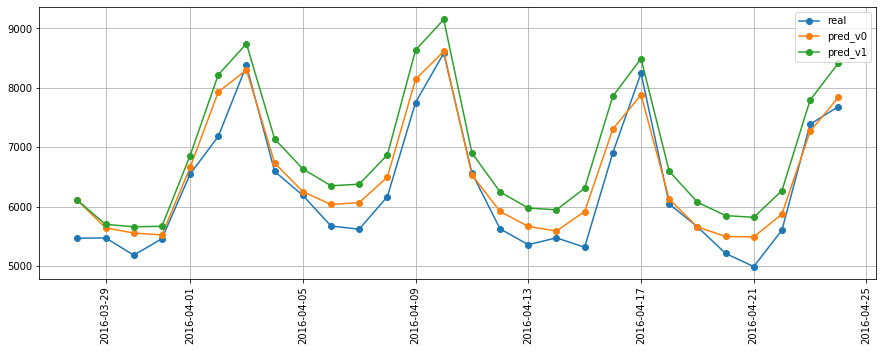

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 4 --------------------------------------------
----------------------------------------------------------------------------------------------------
Building the features
Elapsed time building the features: 4.063217151165008 [min]

Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.143540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5797
[LightGBM] [Info] Number of data points in the train set: 2256675, number of used features: 66
Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsseL12: 0.878987
[50]	valid_0's wrmsseL12: 0.816112
[75]	valid_0's wrmsseL12: 0.798156
[100]	valid_0's wrmsseL12: 0.792928
[125]	valid_0's wrmsseL12: 0.791024

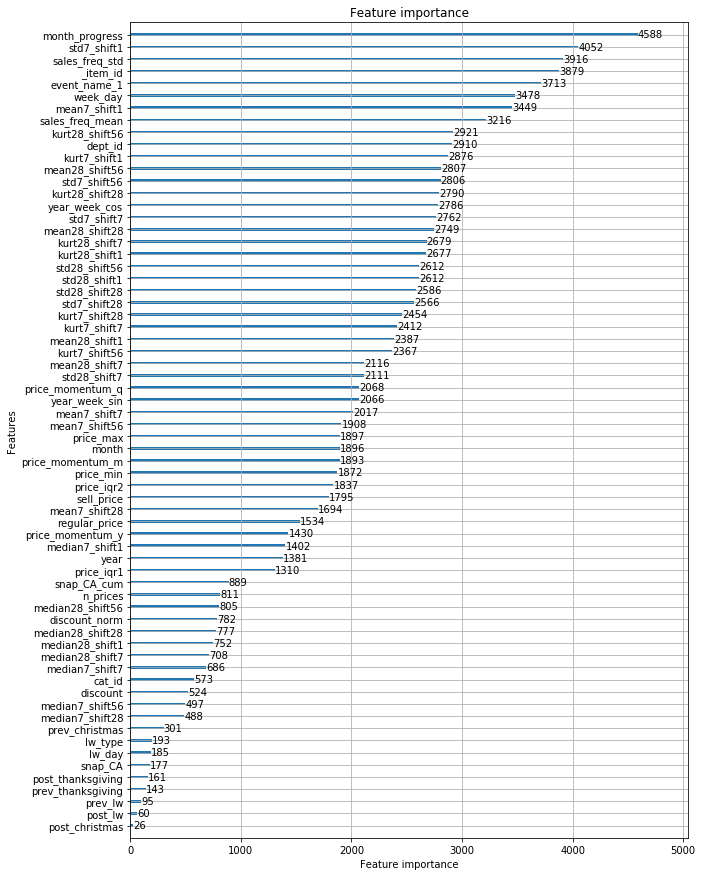

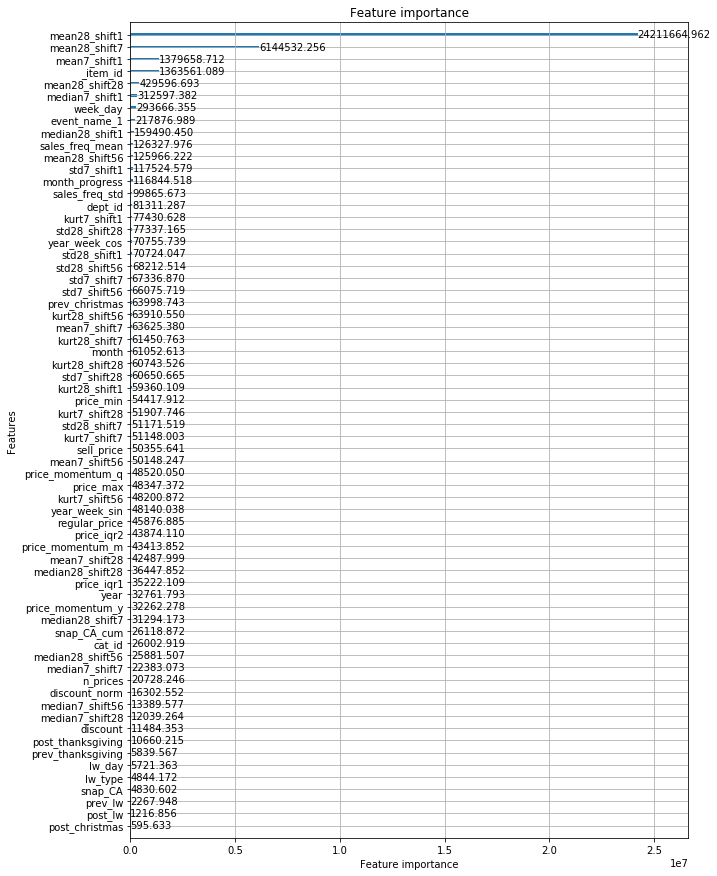

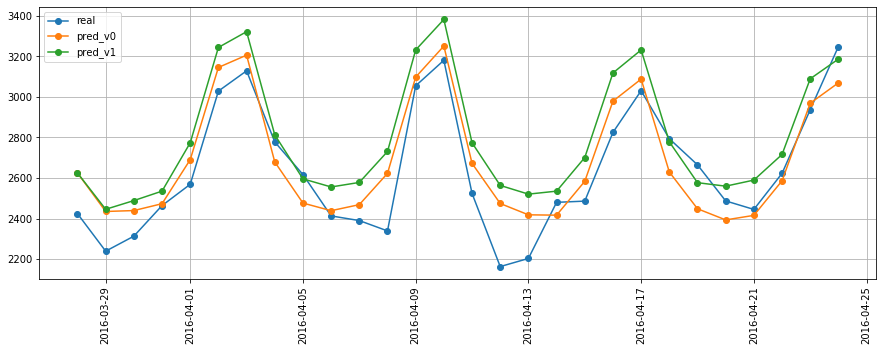

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 5 --------------------------------------------
----------------------------------------------------------------------------------------------------
Building the features
Elapsed time building the features: 4.83777623573939 [min]

Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6052
[LightGBM] [Info] Number of data points in the train set: 2243192, number of used features: 66
Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsseL12: 0.915057
[50]	valid_0's wrmsseL12: 0.802884
[75]	valid_0's wrmsseL12: 0.77015
[100]	valid_0's wrmsseL12: 0.762479
[125]	valid_0's wrmsseL12: 0.760815
[

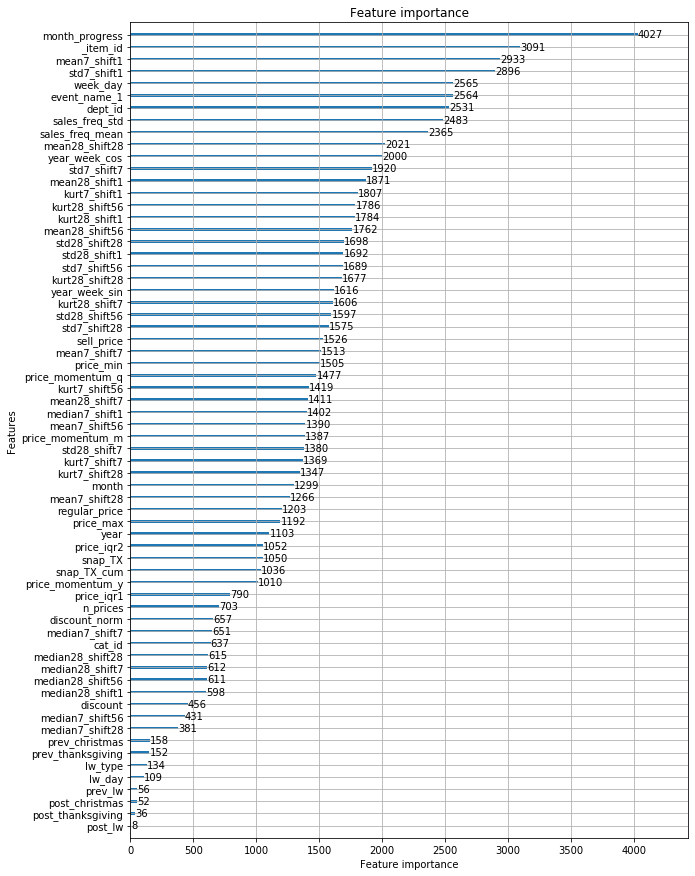

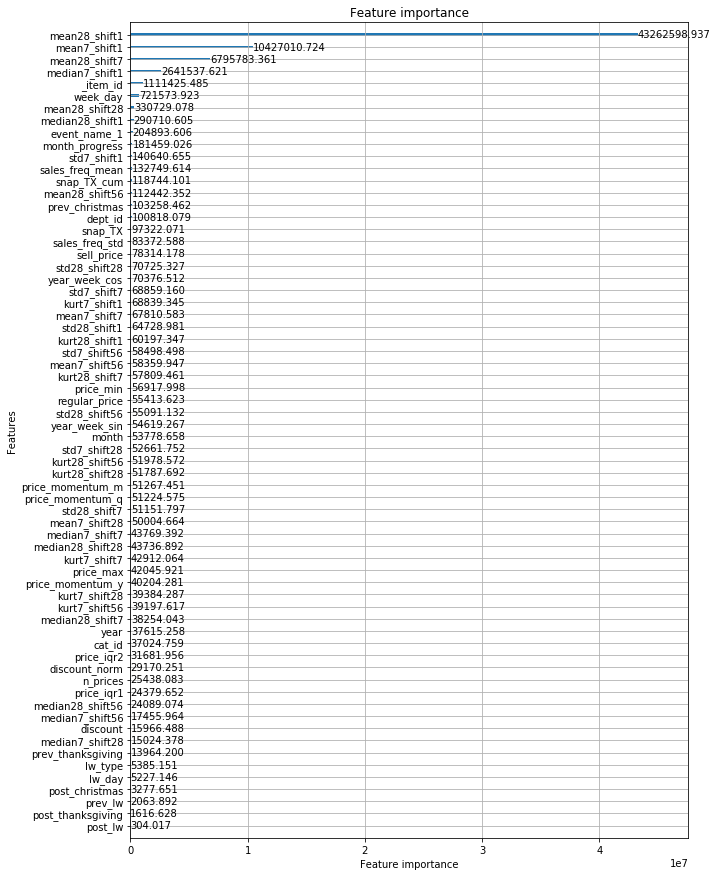

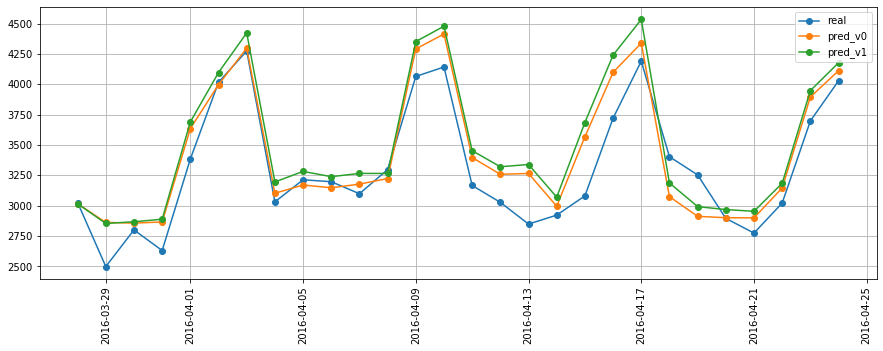

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 6 --------------------------------------------
----------------------------------------------------------------------------------------------------
Building the features
Elapsed time building the features: 4.872888032595316 [min]

Fitting the model


In [ ]:
%%time

print("#"*100)
print(f" Validation period: {valid_period} ".center(100, "#"))
print("#"*100)

valid_start = valid_period[0]
valid_end = valid_period[1]
stores_forecast = list()

for store_id in range(1,11):
    print("-"*100)
    print(f" store_id: {store_id} ".center(100, "-"))
    print("-"*100)

    _train_data = data.query("ds <= @valid_end & store_id == @store_id").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    if store_id in [1,2,3,4]:
        # CA store
        _train_data.drop(["snap_TX", "snap_TX_cum", "snap_WI", "snap_WI_cum"], axis=1, inplace=True)
    elif store_id in [5,6,7]:
        # TX store
        _train_data.drop(["snap_CA", "snap_CA_cum", "snap_WI", "snap_WI_cum"], axis=1, inplace=True)
    else:
        #WI store
        _train_data.drop(["snap_TX", "snap_TX_cum", "snap_CA", "snap_CA_cum"], axis=1, inplace=True)
        
    print("Building the features")
    tic = time.time()
    model_level12 = LightGBMForecaster(**model_kwargs)
    model_level12.prepare_features(train_data=_train_data, valid_index=_valid_index)
    model_level12.train_features.dropna(subset=lagged_features_to_dropna, axis=0, inplace=True)
    model_level12.train_features = reduce_mem_usage(model_level12.train_features)
    model_level12.valid_features = reduce_mem_usage(model_level12.valid_features)
    ts_id_in_train = model_level12.train_features.ts_id.unique()
    model_level12.valid_features = model_level12.valid_features.query("ts_id in @ts_id_in_train")
    tac = time.time()
    print(f"Elapsed time building the features: {(tac-tic)/60.} [min]\n")

    print("Fitting the model")
    tic = time.time()
    evaluator = WRMSSEEvaluatorL12(model_level12.valid_features, weights_level12, scales_level12)
    model_level12.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})
    tac = time.time()
    print(f"Elapsed time fitting the model: {(tac-tic)/60.} [min]")
    print(f"best_iteration: {model_level12.best_iteration} \n")

    lgb.plot_importance(model_level12.model.model, importance_type="split", figsize=(10,15))
    lgb.plot_importance(model_level12.model.model, importance_type="gain", figsize=(10,15))

    print("Predicting with ground thruth lagged values")
    tic = time.time()
    forecast_v0 = (model_level12.valid_features
                   .loc[:, ["ds"]+model_level12.ts_uid_columns]
                   .assign(y_pred = model_level12.model.predict(model_level12.valid_features)))
    tac = time.time()
    print(f"Elapsed time predicting: {(tac-tic)/60.} min \n")

    wrmsse = evaluator._evaluate(forecast_v0.y_pred.values)
    print(f"wrmsse: {wrmsse} \n")

    print("Predicting with recursive approach")
    tic = time.time()
    valid_data = model_level12.valid_features.loc[:, model_level12.raw_train_columns].drop("y", axis=1)
    forecast_v1 = model_level12.predict(valid_data, recursive=True)
    tac = time.time()
    print(f"Elapsed time predicting: {(tac-tic)/60.} min \n")

    wrmsse = evaluator._evaluate(forecast_v1.y_pred.values)
    print(f"wrmsse: {wrmsse} \n")

    mrg = (model_level12.valid_features.groupby(["ds"])["y"].sum().reset_index()
           .merge(forecast_v0.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds")
           .merge(forecast_v1.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds"))
    plt.figure(figsize=(15,5))
    plt.plot_date(mrg.ds, mrg.y, "o-", label="real")
    plt.plot_date(mrg.ds, mrg.y_pred_x, "o-", label="pred_v0")
    plt.plot_date(mrg.ds, mrg.y_pred_y, "o-", label="pred_v1")
    plt.grid()
    plt.xticks(rotation=90)
    plt.legend(loc="best")
    plt.show()

    forecast_v1["store_id"] = store_id
    stores_forecast.append(forecast_v1)
    del model_level12, _train_data, _valid_index, evaluator
    gc.collect()
    
fold_forecast = pd.concat(stores_forecast, ignore_index=True)
mrg = pd.merge(data.loc[:, ["ds","item_id","dept_id","cat_id","store_id","state_id","y"]],
               fold_forecast, how="inner", on=["ds","item_id","store_id"])
evaluator = WRMSSEEvaluator(mrg.loc[:, ["ds","item_id","dept_id","cat_id","store_id","state_id","y"]])
wrmsse = evaluator._evaluate(mrg.y_pred.values)
print("\nwrmsse:", wrmsse)
print(evaluator.errors_by_level)

In [9]:
print("\nwrmsse:", wrmsse)
print(evaluator.errors_by_level)


wrmsse: 0.552956916981722
{'root': 0.3420069163129748, ('state_id',): 0.4085878948135272, ('store_id',): 0.4938733394557209, ('cat_id',): 0.3798347177073118, ('dept_id',): 0.4453343345870821, ('state_id', 'cat_id'): 0.44595603641168247, ('state_id', 'dept_id'): 0.5013829571018912, ('store_id', 'cat_id'): 0.5363399552978062, ('store_id', 'dept_id'): 0.5864854724784648, ('item_id',): 0.8131460139215079, ('item_id', 'state_id'): 0.8334002980334517, ('item_id', 'store_id'): 0.849135067659244}


***